The process for OTE-01 and OTE-02 will be the same, the difference being that OTE-02 will have PSFs that are not saturated and we will have the precise boresight. Both sets of images are expecting to have high backgrounds.

To do:
- get boresight
- get estimate of segment ID


take the locations of the PSFs in the image:
- get the encircled energy and FWHM for each PSF (use the modified poppy functions and photutils?) - we should be able to get that from Shadow
- find distance to boresight center for each
- cut out each psf and put in a 2048x2048 at the locations in the LOS-02 image
    - what happens if there are some PSFs we don't know which one it is?
    - use jwst_magic.convert_image.convert_image_to_raw_fgs.create_seed_image, create my own all_psfs file?

Goals:
- have a sense of what our large image array will look like
- how much we expect each PSF to change
- ideally run it through MAGIC and try to make it work

In [113]:
import os

from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import from_levels_and_colors
from matplotlib import cm
import numpy as np
import pandas as pd

from jwst_magic import convert_image

%matplotlib inline

In [4]:
# DO NOT CHANGE THESE LOCATIONS
SEGMENTS = ["A1-1", "A2-2", "A3-3", "A4-4", "A5-5", "A6-6", 
            "B1-7","B2-9", "B3-11", "B4-13", "B5-15", "B6-17", 
            "C1-8", "C2-10", "C3-12", "C4-14", "C5-16", "C6-18"]
GA_PSF_LOCATIONS = {'A1-1':[1015, 1210],
                    'A2-2':[856, 1116],
                    'A3-3':[864, 931],
                    'A4-4':[1023, 837],
                    'A5-5':[1180, 936],
                    'A6-6':[1185 , 1126],
                    'B1-7':[1011, 1402],
                    'B2-9':[691, 1208],
                    'B3-11':[686, 822],
                    'B4-13':[1027, 676],
                    'B5-15':[1346, 843],
                    'B6-17':[1335, 1213],
                    'C1-8':[854, 1300],
                    'C2-10':[695, 1019],
                    'C3-12':[866, 742],
                    'C4-14':[1188, 744],
                    'C5-16':[1342, 1033],
                    'C6-18':[1172, 1304]
                    }

In [61]:
def distance_to_boresight(x, y, truth_x, truth_y):
    '''
    calculate the distance from the PSF in OTE-01 to it's location in OTE-06/LOS-02
    truth_x and truth_y are the location of the boresight
    '''
    
    return np.sqrt( (truth_x - x)**2 + (truth_y - y)**2 )


In [174]:
def read_shadow_log(filename):
    labels = ['ra_txt', 'dec_txt', 'equinox', 'x', 'y', 'fwhm', 'fwhm_x', 'fwhm_y', 'starsize', 'ellipse', 
          'background', 'skylevel', 'brightness', 'time_local', 'time_ut', 'ra_deg', 'dec_deg']

    info = pd.read_csv(filename, delimiter=' ', skiprows=[0, 1], names=labels)
    
    info_squeezed = info[['x', 'y', 'fwhm', 'fwhm_x', 'fwhm_y', 'starsize', 'ellipse']].copy()
    return info_squeezed

In [220]:
def plot_mosaic_with_psfs(mosaic, car, x_list, y_list, est_target_location, xlim=None, ylim=None):
    """
    Plot out the mosaic image with the identified PSFs and estimated target location plotted
    """
    plt.figure(figsize=(14, 14))
    
    plt.imshow(mosaic, norm=LogNorm())
    plt.scatter(boresight_location[0], boresight_location[1], s=500, marker='*', c='yellow', edgecolor='C1', 
                label='Estimated Target Location')
    for j, (x, y) in enumerate(zip(x_list, y_list)):
        plt.annotate(j, (x, y), (x-15, y-20), c='black')
    
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    
    plt.title(f"{car} Mosaic with labelled PSFs")
    plt.legend()
    plt.show()

In [276]:
def match_psf_params_to_segment(info_df, matching_dictionary, target_location):
    """
    Match the location and other PSF parameters to the segment based on the matching dictionary. Also calculate 
    the distance from each segment to the boresight
    """
    truth_x, truth_y = target_location
    seg_location_dictionary = {matching_dictionary[ind] : {'location': (int(info_df['x'].values[ind]), 
                                                                    int(info_df['y'].values[ind])),
                                                       'fwhm': info_df['fwhm'].values[ind],
                                                       'fwhm_x': info_df['fwhm_x'].values[ind],
                                                       'fwhm_y': info_df['fwhm_y'].values[ind],
                                                       'ellipticity': info_df['ellipse'].values[ind],
                                                       'distance_to_target': distance_to_boresight(info_df['x'].values[ind],
                                                                                                   info_df['y'].values[ind], 
                                                                                                   truth_x, 
                                                                                                   truth_y)
                                                       } for ind in matching_dictionary.keys()}
    return seg_location_dictionary


In [289]:
def get_values(seg_location_dictionary, parameter, decimals=2):
    """
    Get the PSF parameters from the dictionary
    """
    values = []
    for key in seg_location_dictionary:
        values.append(np.round(seg_location_dictionary[key][parameter], decimals))
    return values 
        
def plot_parameters(xs, ys, values, title, cmap=cm.RdYlGn_r):
    """
    Plot the PSF parameters 
    """
    center_x = np.median(xs)
    center_y = np.median(ys)
    
    # plot out new image with distance color coded by how far from boresight
    fig = plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.scatter(xs, ys, marker='o', s=100, c=values, cmap=cmap)
    plt.colorbar()
    plt.ylim(center_y+1024, center_y-1024)
    plt.xlim(center_x-1024, center_x+1024)
    plt.show()
    
def plot_multiple_parameters(parameters, seg_location_dictionary, xs, ys):
    fig, ax = plt.subplots(1, len(parameters), figsize=(6*len(parameters), 6))
    segs = seg_location_dictionary.keys()
    for i, (seg, param) in enumerate(zip(segs, parameters)):
        values = get_values(seg_location_dictionary, param)
        ax[i].annotate(seg, )
        ax[i].scatter(xs, ys, marker='o', s=100, c=values, cmap=cm.RdYlGn_r)
        #TODO: horizontal colorbar for each
        ax[i].set_ylim(2048, 0)
        ax[i].set_xlim(0, 2048)
        ax[i].set_title(param)
        fig.colorbar(pcm, ax=ax)
    

# After OTE-01 

In [6]:
car = 'OTE-01'
program_id = 1134

In [156]:
#### CELL TO EDIT
main_directory = '/ifs/jwst/tel/TeamPractices/'

sw_mosaic = os.path.join(main_directory, 'OTE-01/mosaic0_obs1-2_median_sub_gbrady_05032021.fits')#'OTE-01/Ball_Deployment-2/WARM/output/mosaic0_quip.fits')

In [175]:
#### CELL TO EDIT
info_from_shadow = '/Users/kbrooks/Desktop/pick_log.txt'
info_df = read_shadow_log(info_from_shadow)

In [216]:
#### CELL TO EDIT
# Define boresight_location - get this from Shadow
target_location = (4000, 6000)

In [180]:
# Open image
image = fits.getdata(sw_mosaic)

#correct negative pixels
image[image<=0] = 3e-20

In [182]:
# Get x and y postitions of each identifiable PSF in the MOSAIC
# The identified PSFs might not all be from the target star and some from the target star might be missing
x_list2, y_list2, _, _ = convert_image.convert_image_to_raw_fgs.create_all_found_psfs_file(image, 
                                                                                           guider=1, 
                                                                                           root=None, 
                                                                                           out_dir=None, 
                                                                                           smoothing='default', 
                                                                                           save=False)

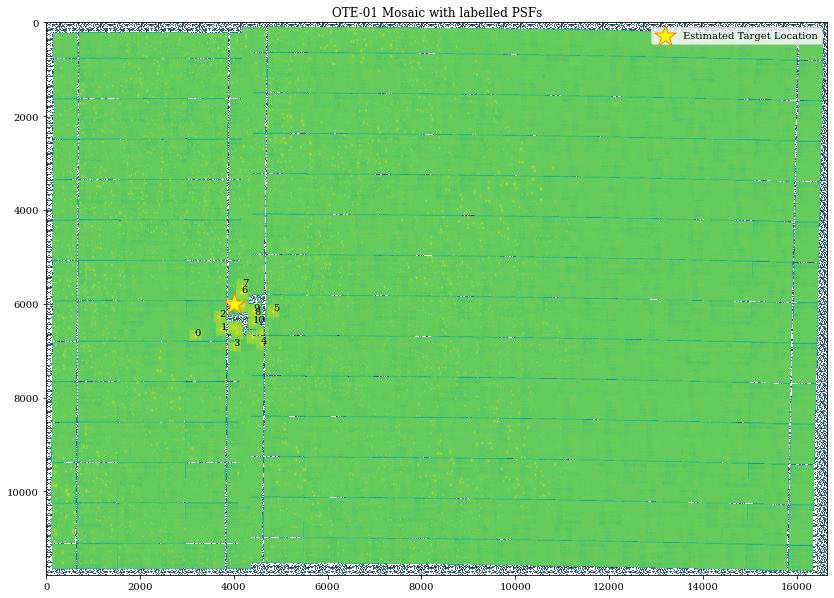

In [221]:
# Plot the full mosaic with the estimated target location and identified PSFs
plot_mosaic_with_psfs(image, car, info_df['x'].values, info_df['y'].values, 
                      target_location, xlim=None, ylim=None)

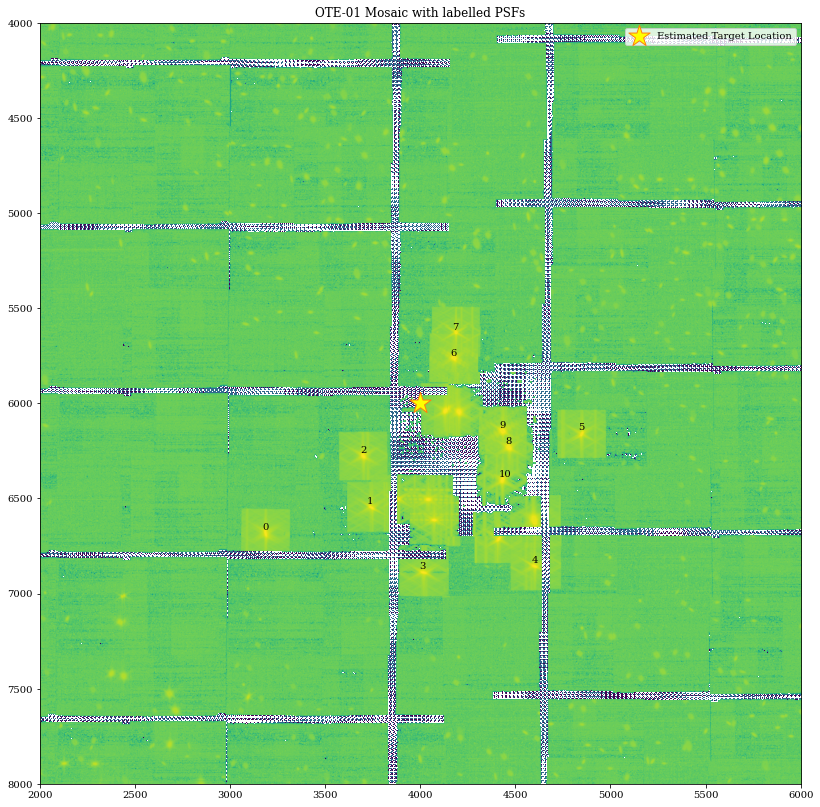

In [222]:
# Zoom in on the identified PSFs
plot_mosaic_with_psfs(image, car, info_df['x'].values, info_df['y'].values, 
                      target_location, xlim=(2000, 6000), ylim=(8000, 4000))

In [192]:
#### CELL TO EDIT
# With the help of Shadow, determine which of the labelled PSFs are associated with a segment
# In the dictionary below, put the number from above BEFORE the ":" for each segment where Shadow thinks we have a
#  match. Delete any entries where the segment is unknown
matching_dictionary = { 1  :'A1-1', 
                        3  :'A2-2', 
                        6  :'A3-3', 
                        0  :'A4-4', 
                        7  :'A5-5', 
                        10 :'A6-6', 
                        4  :'B1-7',
                        5  :'B2-9', 
                        9  :'B3-11', 
                        8  :'B4-13', 
                        2  :'B5-15'#, 
#                         :'B6-17', 
#                         :'C1-8', 
#                         :'C2-10', 
#                         :'C3-12', 
#                         :'C4-14', 
#                         :'C5-16', 
#                         :'C6-18'
                      } 


In [283]:
# Match the location to the segment based on the matching dictionary

seg_location_dictionary = match_psf_params_to_segment(info_df, matching_dictionary, target_location)

In [292]:
# Put known segment postage stamps in large image array locations
box = 60
large_image_array = np.zeros([2048, 2048])

xs = []
ys = []
for seg in seg_location_dictionary.keys():
    mosaic_x, mosaic_y = seg_location_dictionary[seg]['location']
    psf = image[mosaic_y-box:mosaic_y+box, mosaic_x-box:mosaic_x+box]
    ga_x, ga_y = GA_PSF_LOCATIONS[seg]
    xs.append(ga_x)
    ys.append(ga_y)
    large_image_array[ga_y-box: ga_y+box, ga_x-box:ga_x+box] = psf

large_image_array[large_image_array<=0] = 3e-20

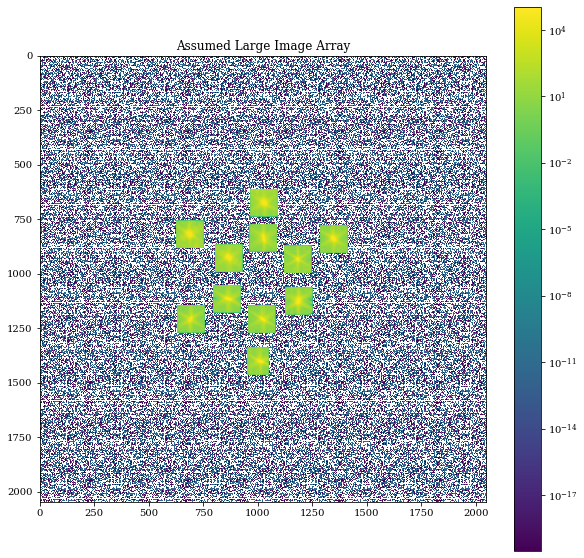

In [293]:
# plot out new image with distance color coded by how far from boresight
plt.figure(figsize=(10, 10))
plt.imshow(large_image_array, norm=LogNorm())
plt.title(f"Assumed Large Image Array")
plt.colorbar()
plt.show()

### Plot heat map of distances from estimated target location 

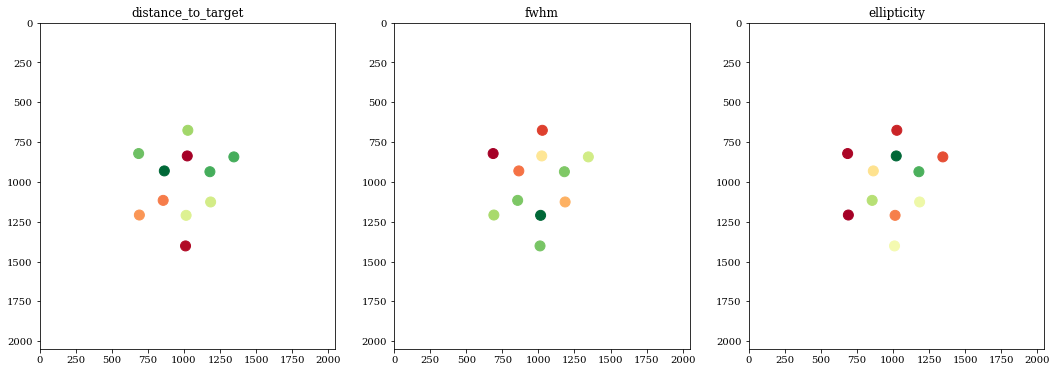

In [287]:
# Look at high level numbers
plot_multiple_parameters(['distance_to_target', 'fwhm', 'ellipticity'], seg_location_dictionary, xs, ys)

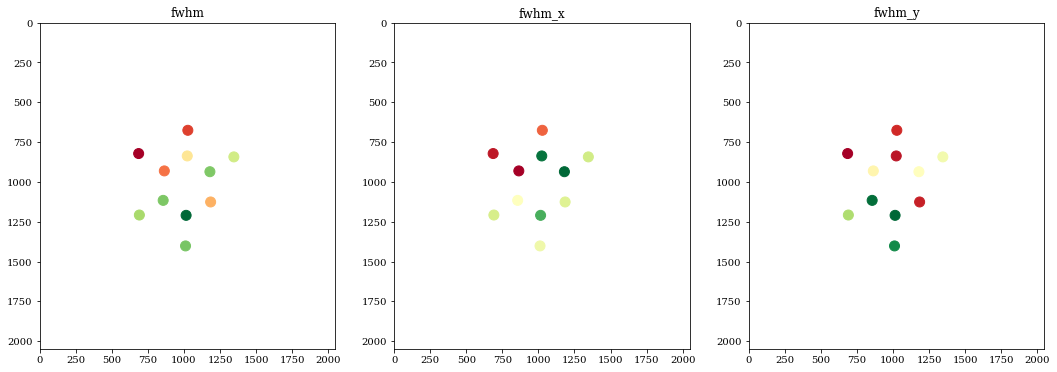

In [288]:
# Break down the FWHM further
plot_multiple_parameters(['fwhm', 'fwhm_x', 'fwhm_y'], seg_location_dictionary, xs, ys)

In [150]:
#TODO: similar plot for FWHM

In [149]:
#TODO: similar plot for EE

In [151]:
#TODO: Each NIRCam detector was downsampled to 500x500, need to upsample each PSF to the correct size for 2048x2048

# OTE-02
Do the same thing as OTE-01, just with better information

# OTE-03
Do the same thing?

# OTE-04
Do the same thing but with actual knowledge of PSF locations

# Get simulated NIRCam locations of LOS-02 PSFs 

In [8]:
los02_image = fits.getdata('/ifs/jwst/tel/LRE5/LOS-02/output/LRE5-RfR/jw01410002001_02101_00001_nrca3_cal.fits')

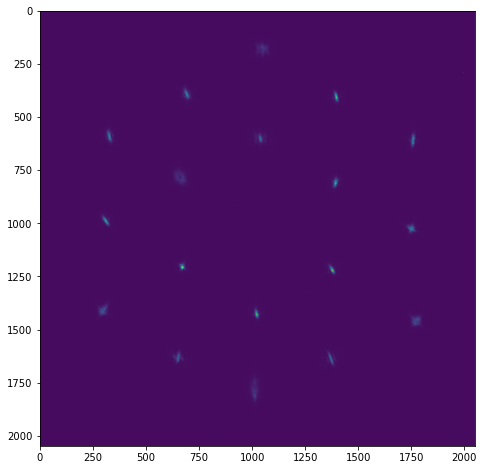

In [9]:
plt.figure(figsize=(10, 8))
plt.imshow(los02_image)

In [10]:
# mapping of magic segment labels to WSS numbers

# Do not change this cell

# MAGIC segment labels to segment naming map
SEGMENT_MAP_G1 = {"A":"B4-13", "B":"C4-14", "C":"C3-12", "D":"B5-15",
                  "E":"A4-4", "F":"B3-11", "G":"A5-5", "H":"A3-3", 
                  "I":"C5-16", "J":"C2-10", "K":"A6-6", "L":"A2-2", 
                  "M":"B6-17", "N":"A1-1", "O":"B2-9", "P":"C6-18", 
                  "Q":"C1-8", "R":"B1-7"}


SEGMENTS = ["A1-1", "A2-2", "A3-3", "A4-4", "A5-5", "A6-6", 
            "B1-7","B2-9", "B3-11", "B4-13", "B5-15", "B6-17", 
            "C1-8", "C2-10", "C3-12", "C4-14", "C5-16", "C6-18"]

In [16]:
guider = 1
segment_map = [SEGMENT_MAP_G1 if guider==1 else SEGMENT_MAP_G2][0]

In [18]:
# Make table
out_dir = '/Users/kbrooks/git_repos/jwst-magic-fork/out/'# +car+out/
root = 'test_los02'
all_psfs_filename = os.path.join(out_dir, root, 
                                 f'unshifted_all_found_psfs_{root}_G{guider}.txt')
all_psfs_table = pd.read_csv(all_psfs_filename, comment='#', 
                             names=['label', f'y', f'x', 
                                    f'countrate'], sep=' ')
segments = [segment_map[label] for label in all_psfs_table['label']]

# Add the segment name to the table
all_psfs_table.insert(1, 'segment', segments)
all_psfs_table = all_psfs_table.sort_values('segment', ascending=True)

In [23]:
all_psfs_locations = all_psfs_table[['segment', 'y','x']]

all_psfs_locations

,segment,y,x
8,A1-1,1015.0,1210.0
4,A2-2,856.0,1116.0
5,A3-3,864.0,931.0
9,A4-4,1023.0,837.0
12,A5-5,1180.0,936.0
13,A6-6,1185.0,1126.0
7,B1-7,1011.0,1402.0
1,B2-9,691.0,1208.0
0,B3-11,686.0,822.0
10,B4-13,1027.0,676.0


In [27]:
truth_locations = all_psfs_locations.set_index('segment').T.to_dict('list')
truth_locations

{'A1-1': [1015.0, 1210.0],
 'A2-2': [856.0, 1116.0],
 'A3-3': [864.0, 931.0],
 'A4-4': [1023.0, 837.0],
 'A5-5': [1180.0, 936.0],
 'A6-6': [1185.0, 1126.0],
 'B1-7': [1011.0, 1402.0],
 'B2-9': [691.0, 1208.0],
 'B3-11': [686.0, 822.0],
 'B4-13': [1027.0, 676.0],
 'B5-15': [1346.0, 843.0],
 'B6-17': [1335.0, 1213.0],
 'C1-8': [854.0, 1300.0],
 'C2-10': [695.0, 1019.0],
 'C3-12': [866.0, 742.0],
 'C4-14': [1188.0, 744.0],
 'C5-16': [1342.0, 1033.0],
 'C6-18': [1172.0, 1304.0]}

In [30]:
truth_locations == ga_psf_locations

True